In [49]:
######## scRNAseq preprocessing ##########

import scanpy as sc
import numpy as np
import pandas as pd

# ----------------------------------------
# 1. Load data
# ----------------------------------------

adata = sc.read_h5ad("pbmc3k_raw.h5ad")  # or your correct file
print(f"✅ Loaded 'pbmc3k' with shape: {adata.shape}")
print("🔎 X dtype:", adata.X.dtype)
print("   Shape:", adata.X.shape)
print("   Contains NaNs?", np.isnan(adata.X.data).any() if hasattr(adata.X, 'data') else np.isnan(adata.X).any())

# ----------------------------------------
# 2. Basic QC metrics
# ----------------------------------------
#Key metrics include: number of genes (ideal: 200–2,500), total counts (1,000–30,000), 
#and mitochondrial percentage (<5–10%). Low gene counts suggest empty droplets, 
#high counts or genes may indicate doublets, and high mitochondrial reads flag stressed or dying cells. 
#Filtering based on these ensures reliable downstream analysis.

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
print("✅ Calculated QC metrics")

# ----------------------------------------
# 3. Filter cells and genes
# ----------------------------------------

adata = adata[adata.obs.n_genes_by_counts > 200, :]          # Remove cells with too few genes
adata = adata[adata.obs.pct_counts_mt < 5, :]                 # Remove high-mitochondrial cells
adata = adata[:, adata.var.n_cells_by_counts > 3]            # Remove rarely expressed genes
adata = adata.copy()  # ✅ Avoids view warning later
print(f"✅ After filtering: {adata.shape}")

# ----------------------------------------
# 4. Normalize and log transform
# ----------------------------------------

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print("✅ Normalized and log-transformed")

# ----------------------------------------
# 5. Highly variable genes (HVGs)
# ----------------------------------------

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata = adata[:, adata.var.highly_variable].copy()  # Filter for HVGs and copy to avoid warning
print(f"✅ Retained {adata.shape[1]} highly variable genes")

# ----------------------------------------
# 6. PCA
# ----------------------------------------

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
print("✅ PCA complete")

# ----------------------------------------
# 7. Compute neighbors and UMAP
# ----------------------------------------

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
print("✅ UMAP computed")

# ----------------------------------------
# 8. Save results
# ----------------------------------------

adata.write("pbmc3k_preprocessed.h5ad")
print("💾 Saved processed dataset to: pbmc3k_preprocessed.h5ad")


✅ Loaded 'pbmc3k' with shape: (2700, 32738)
🔎 X dtype: float32
   Shape: (2700, 32738)
   Contains NaNs? False
✅ Calculated QC metrics
✅ After filtering: (2643, 13034)
✅ Normalized and log-transformed
✅ Retained 2000 highly variable genes
✅ PCA complete
✅ UMAP computed
💾 Saved processed dataset to: pbmc3k_preprocessed.h5ad


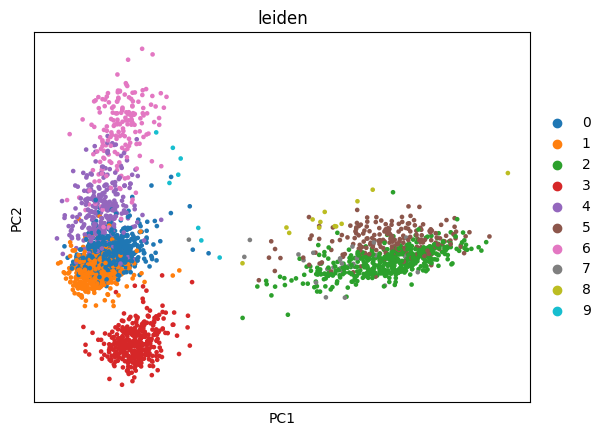

In [38]:
# ----------------------------------------
# Visualization and Figure Export
# ----------------------------------------

# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Run Leiden clustering
sc.tl.leiden(adata, resolution=1.0)

# Now you can plot PCA colored by leiden clusters
sc.pl.pca(adata, color='leiden', save='_pca_clusters.png')

# PCA – Principal Component Analysis:
#Principal Component Analysis (PCA) was applied to the log-normalized expression matrix using the top 2000 highly variable genes. This step reduced the high-dimensional transcriptomic data into a smaller number of orthogonal components (principal components), each capturing a portion of the variance in the dataset. The first few PCs (typically PC1 to PC10) accounted for the majority of biologically relevant variability across cells, such as cell cycle phase, activation state, or lineage identity. Visualizing the cells in PCA space allowed us to assess potential batch effects, detect outliers, and observe preliminary groupings that suggest transcriptional heterogeneity among single cells.

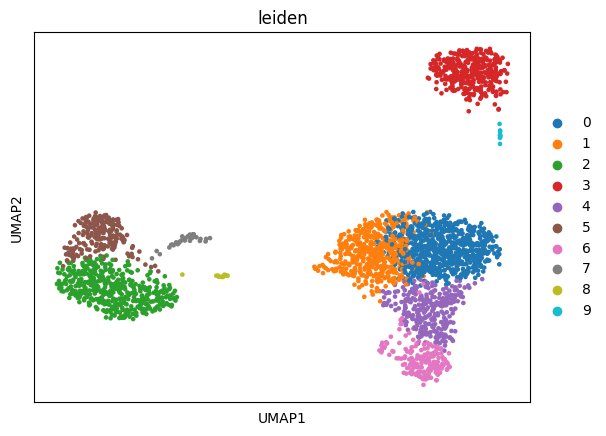

In [39]:
# 2. UMAP with Leiden clusters
sc.pl.umap(adata, color='leiden', save='_umap_clusters.png')
#print("📸 Saved: UMAP with Leiden clusters")

#Clustering – Leiden Algorithm:
#To assign discrete labels to transcriptionally similar groups of cells, we applied the Leiden clustering algorithm to the neighborhood graph constructed during the UMAP step. Leiden clustering identifies communities in the graph based on connectivity patterns, effectively grouping cells into clusters that reflect shared gene expression profiles. In our analysis, the clustering revealed several well-defined groups that were spatially coherent on the UMAP plot. These clusters likely correspond to major PBMC cell types such as T cells, B cells, NK cells, monocytes, and others. This unsupervised approach helps define biologically meaningful subpopulations without prior assumptions.

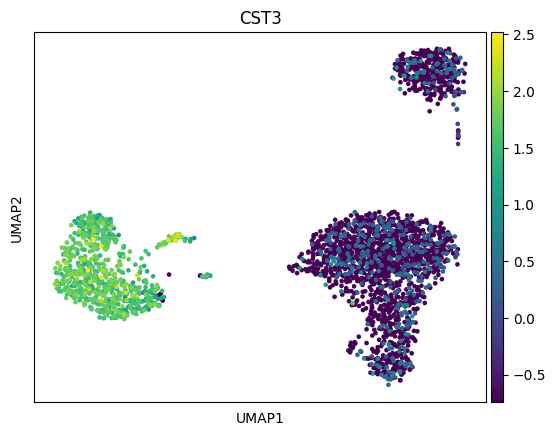

📸 Saved: Marker gene UMAP for CST3


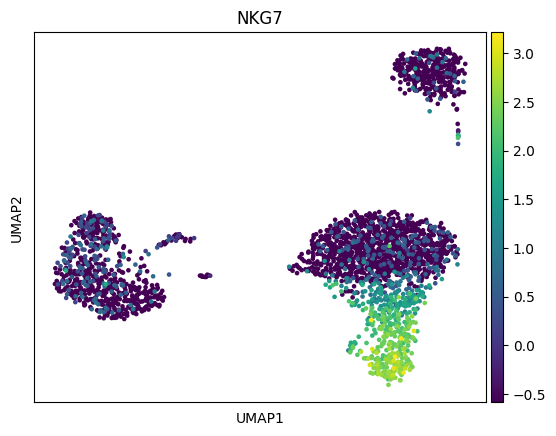

📸 Saved: Marker gene UMAP for NKG7


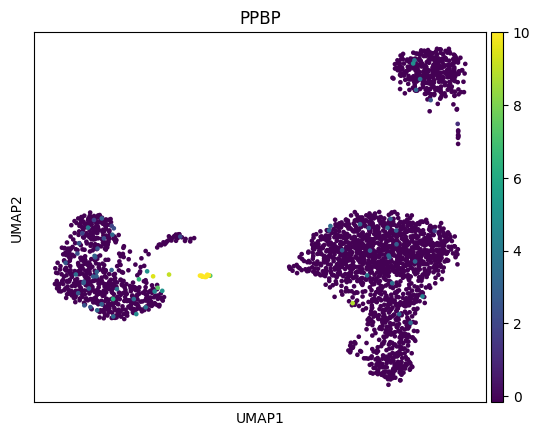

📸 Saved: Marker gene UMAP for PPBP


In [40]:
# 3. UMAP with marker gene expression
marker_genes = ['CST3', 'NKG7', 'PPBP'] #genes of interest, change base on your project
for gene in marker_genes:
    if gene in adata.var_names:
        sc.pl.umap(adata, color=gene, save=f'_marker_{gene}.png')
        print(f"📸 Saved: Marker gene UMAP for {gene}")
    else:
        print(f"⚠️ Marker gene {gene} not found in dataset")

#Expression of Marker Genes on UMAP:
#To interpret the identified clusters biologically, we visualized the expression of canonical marker genes across the UMAP embedding. For example, CST3 marked monocytes, NKG7 highlighted NK cells, and PPBP was expressed in platelets. These marker patterns aligned well with the spatial layout of UMAP clusters, validating the cluster identities and demonstrating that the algorithm captured true biological signal. Such marker-based validation is essential for downstream cell type annotation and functional interpretation.


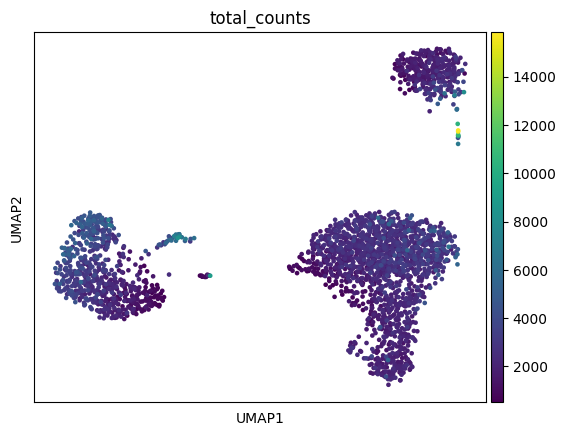

📸 Saved: QC metric UMAP for total_counts


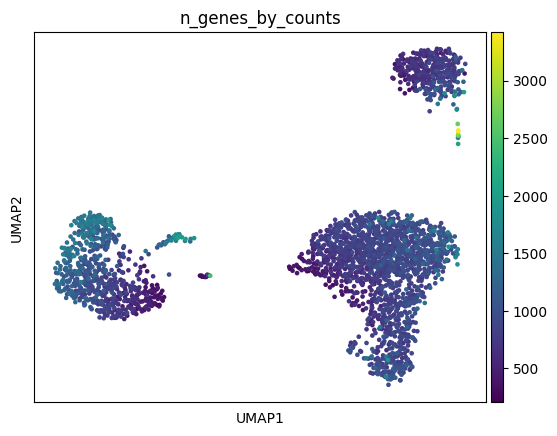

📸 Saved: QC metric UMAP for n_genes_by_counts


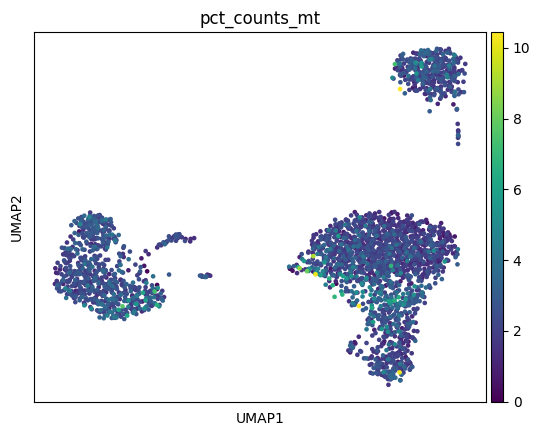

📸 Saved: QC metric UMAP for pct_counts_mt


In [45]:
# 4. UMAP colored by QC metrics
qc_metrics = ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
for metric in qc_metrics:
    if metric in adata.obs.columns:
        sc.pl.umap(adata, color=metric, save=f'_qc_{metric}.png')
        print(f"📸 Saved: QC metric UMAP for {metric}")
    else:
        print(f"⚠️ QC metric {metric} not available")

# As a sanity check, we plotted QC metrics (such as total UMI counts, 
# number of detected genes, and mitochondrial gene percentage) over the UMAP 
# coordinates. These overlays help assess whether technical variation (e.g., 
# library size, damaged cells) is driving cluster separation.
# In our dataset, no dominant QC trend was observed across clusters, suggesting 
# that biological rather than technical differences primarily structure the identified subpopulations. 
# This adds confidence in the integrity of the data and in the conclusions drawn from clustering.


In [ ]:
# Save QC violin plots 
# ----------------------------------------
qc_metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']

for metric in qc_metrics:
    sc.pl.violin(
        adata,
        keys=metric,
        jitter=0.4,
        show=False,
        save=f'_violin_{metric}.png'
    )

#The violin plots summarize QC metrics across cells, showing a healthy distribution of gene counts and library sizes, with a few low-complexity or high-mitochondrial cells that may need filtering. These visualizations help confirm that most cells are of good quality for downstream analysis.
#Quality control (QC) in single-cell RNA-seq helps identify low-quality or problematic cells before downstream analysis. Three core metrics are typically examined: number of genes detected, total counts per cell, and percent mitochondrial content. A healthy cell typically expresses 200–2,500 genes and has total counts between 1,000–30,000, though these ranges can vary by dataset. Cells with fewer than 200 genes or extremely high gene or count values may be low-complexity captures or doublets (two cells sequenced as one). The percentage of mitochondrial transcripts is used to assess cell health—>5–10% often indicates stress, apoptosis, or rupture. Cells outside these ranges are typically excluded to ensure the remaining data reflects biologically valid single cells.
